# Cluster Plot

Prototype for the Cluster plot widget. Currently works for 5 dimensional maps. A Poincare map for the Semiclassical Duffing Oscillator is used as an example. The `Load_Cut` functions loads along trajectory from a csv file in the form we need. The Cluster plot widget is designed to find good values for the parameters `thres` and `band` for the `FindUPO` function. For more information, scroll down to the Testing section.  

In [1]:
import numpy as np
import scipy.integrate as spi 
from math import cos, pi, sin
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3   # Can be commented out without affecting funcionality
mpld3.enable_notebook()
from scipy.optimize import minimize
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual, fixed
import ipywidgets as widgets
from itertools import cycle
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
import csv as csv


### Code

In [2]:
'''
Poincare return map for Semiclassical Duffing with No Noise
r0: Initial condition [5 by 1 list\array] 
RETURNS: [5 by 1 array]
'''
def SnDuffP(r0):
    #Parameters
    Gamma = 0.1
    g = 0.3
    omega = 1
    beta = 0.2
    theta = 0
    dens = 3000
    u = 1
    u1 = u*cos(theta)
    u2 = u*sin(theta)
    
    def f(r,t):
        x = r[0]
        p = r[1]
        sx = r[2]
        sp = r[3]
        sxp = r[4]
        z = r[5]
    
        dxdt = p
        dpdt = -(beta**2)*(x**3 + 3*sx*x) + x - 2*Gamma*p + (g/beta)*cos(omega*t)
        dsxdt = 2.0*sxp + 0.5*Gamma*(1.0 - 4.0*(sxp**2 - sx + sx**2) +u1*(-1.0+4.0*((sxp**2) + sx - sx**2))+4.0*u2*(-sxp+2.0*sxp*sx))      
        dspdt = 2.0*sxp - 6.0*(beta**2)*sxp*(x**2+sx) + 0.5*Gamma*(1.0-4.0*sp-4.0*(sp**2)-4.0*sxp**2 + u1*(1.0-4.0*sp+4.0*(sp**2)-4.0*sxp**2)+4.0*u2*(-sxp+2.0*sxp*sp))       
        dsxpdt = -2.0*Gamma*(sxp*(sp+sx) - u1*sxp*(sp-sx)-0.25*u2*(1.0-2.0*sp+4.0*(sxp**2)-2.0*sx+4.0*sp*sx)) + sp +sx -3.0*(beta**2)*sx*(x**2+sx)       
        dzdt = 1
        drdt = np.array([dxdt,dpdt, dsxdt, dspdt, dsxpdt,dzdt])
    
    
        return drdt
    r0 = np.array([r0[0],r0[1],r0[2],r0[3],r0[4],0])
    out = spi.odeint(f,r0,np.linspace(0,2*pi/omega,dens))[-1]
    out = np.array([out[0],out[1],out[2],out[3],out[4]])
    return out


In [3]:
'''
Loads 5-d data and calculates how far each point moves after a specified number of  applications of the map
(appends as a 6th value). Chooses points that move less than a specificied cut-off value. Returns array.
filename: name of csv file in form 'file.csv'
cutoff: maximum distance cutoff value [positive float]
n: number of iterations of the map [positive integer]
maxpts:  maximum number of points [positive integer] (optional)
'''
def Load_Cut(filename,cutoff,n,maxpts = 50000):
    # Read csv
    a = pd.read_csv('31_05.csv',header = None)
    lmter = 1
    #lbar = FloatProgress(min=0, max=len(a)-n-1) # Loading bar
    #display(lbar)
    for i in range(0,len(a)-n-1,1):
        #lbar.value = i
        if lmter <= maxpts:
            #now
            b = np.array([a.iat[i,0],a.iat[i,1],a.iat[i,2],a.iat[i,3],a.iat[i,4]])
            #next
            c = np.array([a.iat[i+n,0],a.iat[i+n,1],a.iat[i+n,2],a.iat[i+n,3],a.iat[i+n,4]])
            # distance moved
            dist = np.inner(b-c,b-c)
            lmter += 1
            # dataframe ammendment
            if dist < cutoff:
                a.iat[i,5] = dist
            else: a = a.drop(a.index[i])
        else: a = a.drop(a.index[i])           
    return a.as_matrix   

'''
Alternative (much faster)
'''

def Load_Cut2(datafile, cutoff, n, maxpts = 200000):
    # Import datafile
    file = open(datafile, 'r')
    datareader = csv.reader(file,delimiter=',')
    data = []
    lmter = 0
    for row in datareader:
        if lmter < maxpts:
            data.append(row) 
            lmter += 1 
        else: break 
    for i in range(0,len(data),1):
        for j in range(0,len(data[i]),1):
            data[i][j] = float(data[i][j])
    
    # Distance moved at nth point 
    def distmoved(i):
        arr = np.array([data[i][0],data[i][1],data[i][2],data[i][3],data[i][4]]) - np.array([data[i+n][0],data[i+n][1],data[i+n][2],data[i+n][3],data[i+n][4]])
        return np.inner(arr,arr)
         
    # Collects points that move less than cutoff    
    under = []
    for i in range(0,len(data)-n,1):
        dist = distmoved(i)
        if dist < cutoff:
            under.append([data[i][0],data[i][1],data[i][2],data[i][3],data[i][4],dist])
            
    return under


In [26]:
'''
Function for interactive widget ClustPlt.
data: [6 by n] array where there are n data points and data[i] = [r0,...,r4,dist(r)]  for all i where dist [i] is 
      distance moved by point. Load_Cut outputs this form of array.
cluster: [True/False] Decides whether to perform clustering or not.
coord1/coord2: [integer 0 to 4] co-ordinate axis to plot.
pointsize: [Float] Size of points for matplotlib scatter. 
plotsize: [Float] Size of matplotlib plot.
thres: [Float] Maximum distance moved for a point to be plotted.
band: [Float] Bandwidth for the clustering algorithm - roughly proportional t0 the size of clusters it will find
RETURNS: A plot of reccurring points with different colours for different clusters if clustering is True.
'''
def ClustPlt_func(data, cluster, coord1 , coord2 , point_size , plot_size, thres, band):
    
    # scale bandwith
    band = band/100
    
    # Type check
    coord1 = int(coord1)
    coord2 = int(coord2)
    
    def distmoved(i):
        return data[i][5]
    
    # Collects points that move less than thres  
    under = []
    for i in range(0,len(data),1):
        dist = distmoved(i)
        if dist < thres:
            under.append([data[i][0],data[i][1],data[i][2],data[i][3],data[i][4]])
        
    # Co-ordinate Labels 
    coordlabels = ['x','p', 'vx', 'vp','vxp']
        
    if cluster == False:  
        # Plots x and p values of points
        plt.figure(figsize=(plot_size,plot_size))
        plt.scatter(np.transpose(under)[coord1],np.transpose(under)[coord2],s=point_size)
        plt.xlabel(coordlabels[coord1])
        plt.ylabel(coordlabels[coord2])
        plt.show()
        print('Threshold: ', thres)
        print('Total number of points: ', len(under))   
        
    if cluster == True:
        # Performs meanshift clustering
        ms = MeanShift(bandwidth=band, bin_seeding=True)
        ms.fit(under)
        labels = ms.labels_  #gives cluster label of datapoint in the same place of that datapoint in array
        labels_unique = np.unique(labels)
        n_clusters = len(labels_unique)
        cluster_centers = ms.cluster_centers_
        
        # Plots clusters in differnent colors
        colors = cycle('grbcmykbgrcmykbgrcmykbgrcmyk')
        plt.figure(figsize=(plot_size,plot_size))
        for k, col in zip(range(n_clusters), colors): # gives (k=0,col=g),(k=1,col=r),...
            # collects all points of given cluster
            tmp = []
            for i in range(len(labels)):
                if labels[i] == k:
                    tmp.append(data[i])
            tmp = np.transpose(tmp)
            # plots points of cluster in given colour 
            plt.scatter(tmp[coord1],tmp[coord2],color = col,s = point_size)
            #plots centre of cluster
            plt.scatter(cluster_centers[k][coord1],cluster_centers[k][coord2],color = col, marker = '+')
        plt.xlabel(coordlabels[coord1])
        plt.ylabel(coordlabels[coord2])
        plt.show()
        
        print('Total number of points: ', len(under))
        print('Number of clusters: ', n_clusters)
        print('Threshold: ', thres)
        print('Bandwidth: ', band)
        

In [27]:
'''
Widget for ClustPlt_func.
data: [6 by n] array where there are n data points and data[i] = [r0,...,r4,dist(r)]  for all i where dist [i] is 
      distance moved by point. Load_Cut outputs this form of array.
thresopt: [3 by 1 array] options for ClustPlt_func parameter thres in form [min, max, default]
bandopt: [3 by 1 array] options for ClustPlt_func parameter band in form [min, max, default]
'''
def ClustPlt(data, thresopt = [0,2,1], bandopt = [0,50,10]):
    interact(ClustPlt_func,
             data = fixed(data),
             cluster = False,
             coord1 = {'x': 0, 'p':1, 'vx':2, 'vp':3, 'vxp':4},
             coord2 = {'x': 0, 'p':1, 'vx':2, 'vp':3, 'vxp':4},
             plot_size = widgets.FloatSlider(min = 5, max = 15, step = 0.05, value = 7),
             point_size =  widgets.IntSlider(min = 1, max = 30, step = 1, value = 10),
             thres = widgets.FloatSlider(min = thresopt[0], max = thresopt[1], step = 0.01, value = thresopt[2]),
             band = widgets.FloatSlider(min = bandopt[0], max = bandopt[1], step = 0.1, value = bandopt[2]))
    

### Testing

In [4]:
per1 = Load_Cut2('31_05.csv',1,1)
per2 = Load_Cut2('31_05.csv',1,2)
per5 = Load_Cut2('31_05.csv',1,5)


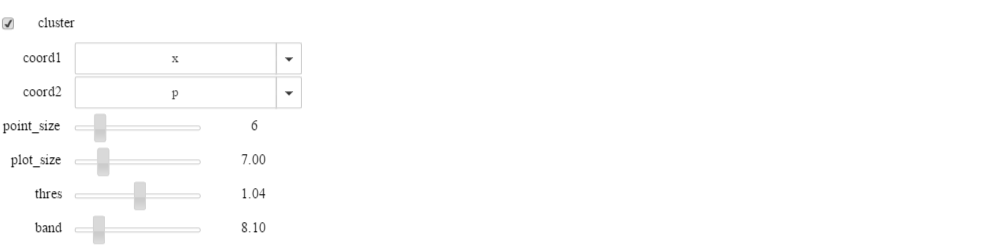

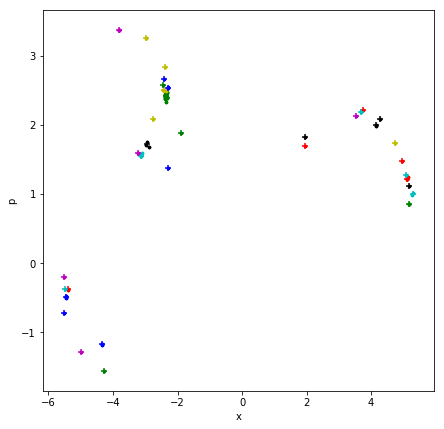

Total number of points:  234
Number of clusters:  36
Threshold:  1.04
Bandwidth:  0.081


In [30]:
ClustPlt(per5)

The widget will identify clusters for given values of `thres` and `band`.The clusters are plotted in different colours and the center of the clusters are marked with a +. The clustering algorithm tends to fail for low numbers of points. Failure is in general indicated by + markers floating by themselves. 

### Development

2


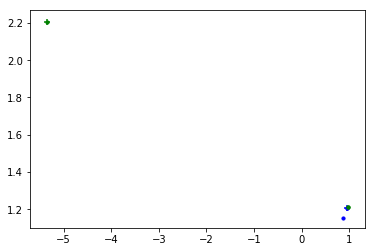

In [25]:
# Plots clusters in different colours for data
#data = np.transpose(np.delete(np.transpose(per1),-1,axis=0))
thres= 0.7
under = []
for i in range(0,len(per1),1):
    dist = per1[i][5]
    if dist < thres:
        under.append([data[i][0],data[i][1],data[i][2],data[i][3],data[i][4]])
ms = MeanShift(bandwidth=0.11, bin_seeding=True)
ms.fit(under)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print(n_clusters_)
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    tmp = []
    for i in range(len(labels)):
        if labels[i] == k:
            tmp.append(data[i])
    tmp = np.transpose(tmp)
    plt.scatter(cluster_centers[k][0],cluster_centers[k][1],color = col, marker = '+')
    plt.scatter(tmp[0],tmp[1],color = col,s = 10)
plt.show()


